<a href="https://colab.research.google.com/github/neuromorph/TweetEval-Sentiment-HF/blob/main/TweetEval_Sentiment_HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers[sentencepiece] datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import transformers, datasets

In [4]:
from datasets import load_dataset

In [5]:
senti_ds = load_dataset("tweet_eval", "sentiment")
senti_ds

Reusing dataset tweet_eval (/root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train_ds = senti_ds["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 45615
})

In [6]:
train_ds[0], len(train_ds)

({'label': 2,
  'text': '"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"'},
 45615)

In [7]:
train_df = pd.DataFrame(train_ds)
# train_df = senti_df["train"][:]
train_df.head()

,text,label
0,"""QT @user In the original draft of the 7th boo...",2
1,"""Ben Smith / Smith (concussion) remains out of...",1
2,Sorry bout the stream last night I crashed out...,1
3,Chase Headley's RBI double in the 8th inning o...,1
4,@user Alciato: Bee will invest 150 million in ...,2


In [8]:
def label_int2str(row):
    return train_ds.features["label"].int2str(row)

train_df["label_name"] = train_df["label"].apply(label_int2str)
train_df.head()

,text,label,label_name
0,"""QT @user In the original draft of the 7th boo...",2,positive
1,"""Ben Smith / Smith (concussion) remains out of...",1,neutral
2,Sorry bout the stream last night I crashed out...,1,neutral
3,Chase Headley's RBI double in the 8th inning o...,1,neutral
4,@user Alciato: Bee will invest 150 million in ...,2,positive


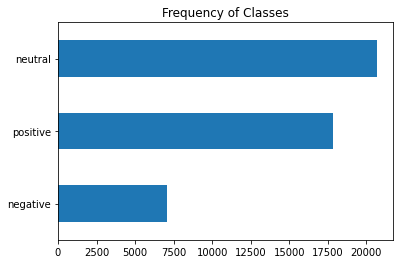

In [38]:

train_df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


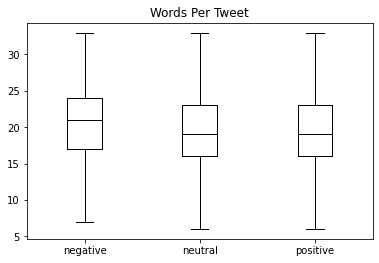

In [ ]:
train_df["Words Per Tweet"] = train_df["text"].str.split().apply(len)
train_df.boxplot("Words Per Tweet", by="label_name", grid=False,
          showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [14]:
!pip3 install sentencepiece

In [3]:
from transformers import AutoTokenizer, DataCollatorWithPadding

model_ckpt = "microsoft/deberta-v3-small"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, use_fast=False)

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True)
    
tokenize(train_ds[0])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'input_ids': [1, 307, 56517, 1944, 11576, 344, 262, 1020, 3921, 265, 262, 574, 474, 550, 261, 80532, 63619, 6657, 262, 6950, 265, 42509, 260, 953, 24428, 109232, 5396, 16099, 25677, 10161, 309, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [11]:
train_ds[0]

{'label': 2,
 'text': '"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"'}

In [10]:
senti_tok = senti_ds.map(tokenize, batched=True, batch_size=None)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

senti_tok = senti_tok.remove_columns(['text'])


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [11]:
senti_tok["train"], senti_tok["validation"], senti_tok["test"]

(Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 45615
 }), Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 2000
 }), Dataset({
     features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 12284
 }))

In [12]:
import torch
from transformers import AutoModelForSequenceClassification

num_labels = 3
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))
device, torch.cuda.get_device_name(0)

Downloading:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

(device(type='cuda'), 'Tesla K80')

In [ ]:
# import torch
# torch.cuda.is_available()

In [13]:
import sklearn
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [14]:

from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [15]:
from transformers import Trainer, TrainingArguments

batch_size = 128
logging_steps = len(senti_tok["train"]) // batch_size
model_name = "finetuned-tweet_eval-sentiment"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=4,
                                  learning_rate=5e-5,
                                  warmup_ratio=0.1, 
                                  lr_scheduler_type='cosine',
                                  fp16=True,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size*2,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  save_strategy="epoch",
                                  push_to_hub=True,
                                  log_level="error")

In [ ]:
# from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=senti_tok["train"],
                  eval_dataset=senti_tok["validation"],
                  tokenizer=tokenizer)
trainer.train();

Cloning https://huggingface.co/deepgai/finetuned-tweet_eval-sentiment into local empty directory.


Download file pytorch_model.bin:   0%|          | 1.83k/255M [00:00<?, ?B/s]

Download file runs/May08_07-11-10_12c3ac13ab9b/1651993890.624564/events.out.tfevents.1651993890.12c3ac13ab9b.7…

Download file runs/May08_07-14-25_12c3ac13ab9b/1651994077.887034/events.out.tfevents.1651994077.12c3ac13ab9b.7…

Download file runs/May08_07-11-10_12c3ac13ab9b/events.out.tfevents.1651993890.12c3ac13ab9b.74.0:  54%|#####3  …

Download file training_args.bin: 100%|##########| 3.05k/3.05k [00:00<?, ?B/s]

Clean file runs/May08_07-11-10_12c3ac13ab9b/1651993890.624564/events.out.tfevents.1651993890.12c3ac13ab9b.74.1…

Clean file runs/May08_07-14-25_12c3ac13ab9b/1651994077.887034/events.out.tfevents.1651994077.12c3ac13ab9b.74.3…

Clean file runs/May08_07-11-10_12c3ac13ab9b/events.out.tfevents.1651993890.12c3ac13ab9b.74.0:  29%|##9       |…

Clean file training_args.bin:  33%|###2      | 1.00k/3.05k [00:00<?, ?B/s]

Download file runs/May08_07-14-25_12c3ac13ab9b/events.out.tfevents.1651994077.12c3ac13ab9b.74.2:  56%|#####6  …

Clean file runs/May08_07-14-25_12c3ac13ab9b/events.out.tfevents.1651994077.12c3ac13ab9b.74.2:  17%|#7        |…

Clean file pytorch_model.bin:   0%|          | 1.00k/255M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.717100,0.599963,0.739500,0.736560
2,0.515200,0.584420,0.746000,0.744879
3,0.385400,0.643124,0.737000,0.736130


In [27]:

preds_valid = trainer.predict(senti_tok["validation"])
preds_valid

PredictionOutput(predictions=array([[-3.498 ,  2.238 ,  0.896 ],
       [-3.31  ,  0.6953,  2.596 ],
       [-1.195 ,  1.555 , -0.3865],
       ...,
       [-3.559 ,  0.7744,  2.428 ],
       [ 1.6045, -0.2235, -1.707 ],
       [-3.701 ,  2.135 ,  1.255 ]], dtype=float16), label_ids=array([1, 2, 0, ..., 2, 1, 1]), metrics={'test_loss': 0.6374549269676208, 'test_accuracy': 0.733, 'test_f1': 0.7334064833110073, 'test_runtime': 17.0511, 'test_samples_per_second': 117.294, 'test_steps_per_second': 0.938})

In [1]:
preds_test = trainer.predict(senti_tok["test"])
preds_test.metrics

NameError: ignored

In [2]:
model.push_to_hub('distilbert-base-uncased-finetuned-tweet_eval-sentiment')

NameError: ignored

In [32]:
tokenizer.push_to_hub('distilbert-base-uncased-finetuned-tweet_eval-sentiment')

In [20]:
# import os
# try:
#     device_name = os.environ['COLAB_TPU_ADDR']
#     TPU_ADDRESS = 'grpc://' + device_name
#     print('Found TPU at: {}'.format(TPU_ADDRESS))
# except KeyError:
#     print('TPU not found')

Found TPU at: grpc://10.19.119.66:8470


In [21]:
# pip install cloud-tpu-profiler

In [ ]:
# !capture_tpu_profile --service_addr 10.19.119.66:8470 --monitoring_level 2

In [26]:
# import subprocess
# subprocess.Popen(["capture_tpu_profile", "--service_addr={}".format(os.environ['COLAB_TPU_ADDR'])])

In [31]:
!pip install GPUtil
from GPUtil import showUtilization as gpu_usage
gpu_usage()

  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=8565645f11fd38035d9a8db8f5a5c7618e5c5e2ff36c362c16da39ecb6b87b4a
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
| ID | GPU | MEM |
------------------
|  0 |  0% | 98% |


In [34]:
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 |  0% | 33% |


In [33]:
del model

import gc
gc.collect()

torch.cuda.empty_cache()